<a href="https://colab.research.google.com/github/qhansen628/Predictive-Vision-Model-Experiments/blob/main/recurrent_attention_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Description

-input:
- Image patch location
- Image patch flattened

output:
- classification label prediction (y_hat)
- next location choice (x_loc)
- next location patch prediction (image_patch prediction)
- hidden activations

# fuck it we do step at a time

Reconstruction network:
- given predefined sequence of patches
- RNN output reconstructed entire image x at each timestep

Idea:
-

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def extract_and_shuffle_patches(images, patch_size, stride):
    batch_size, height, width, channels = images.shape
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, stride, stride, 1],
        rates=[1, 1, 1, 1],
        padding='SAME'
    )
    # Calculate number of patches and reshape to (batch_size, num_patches, patch_size*patch_size*channels)
    num_patches_per_row = (height + stride - 1) // stride
    num_patches_per_col = (width + stride - 1) // stride
    num_patches = num_patches_per_row * num_patches_per_col
    patches = tf.reshape(patches, [batch_size, num_patches, patch_size * patch_size * channels])

    # Ensure patches are float32 if needed (commonly images are in float32)
    patches = tf.cast(patches, tf.float32)

    # Prepare positions and duplicate
    positions = tf.eye(num_patches, dtype=tf.float32)  # One-hot encoding of positions

    # Duplicate patches and positions
    patches_doubled = tf.concat([patches, patches], axis=1)
    positions_doubled = tf.concat([positions, positions], axis=0)

    # Shuffle patches and positions within each batch
    shuffled_indices = tf.map_fn(lambda x: tf.random.shuffle(tf.range(2 * num_patches)), tf.range(batch_size), dtype=tf.int32)
    shuffled_patches = tf.gather(patches_doubled, shuffled_indices, batch_dims=1)
    shuffled_positions = tf.gather(positions_doubled, shuffled_indices, axis=0)

    # Concatenate patches with positions
    full_inputs = tf.concat([shuffled_patches, shuffled_positions], axis=2)
    #full_inputs = tf.concat([patches_doubled, positions_doubled], axis=2)

    return full_inputs, shuffled_positions, shuffled_indices

# Example usage with MNIST
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0  # Normalize
x_train = x_train[..., tf.newaxis]  # Add channel dimension

# Extract patches
patch_size = 4
stride = 4
inputs, positions, indices = extract_and_shuffle_patches(x_train[:10], patch_size, stride)

print(f"Input shape: {inputs.shape}")  # Should show a reduced sequence length



Input shape: (10, 98, 65)


In [ ]:
class ImageReconstructionRNN(tf.keras.Model):
    def __init__(self, patch_size, stride, input_dim, units, output_size):
        super().__init__()
        self.rnn = tf.keras.layers.SimpleRNN(units, return_sequences=False)
        self.dense0 = tf.keras.layers.Dense(output_size//2, activation='relu')
        self.dense = tf.keras.layers.Dense(output_size, activation='relu')  # Assuming normalized images

    def call(self, inputs):
        rnn_output = self.rnn(inputs)
        l2 = self.dense0(rnn_output)
        reconstructed_image = self.dense(l2)
        return reconstructed_image

# Initialize the model
image_height, image_width = 28, 28  # For example, with MNIST
patch_size = 4
stride = 4
units = 128
output_size = image_height * image_width  # Flattened image reconstruction

model = ImageReconstructionRNN(patch_size, stride, patch_size**2, units, output_size)


Idea:

have an rnn model recieve a sequence of patches/patch locations.

Reconstruct entire image from context vector. not each patch separately...

this reconstructed

Epoch 1/10
Training loss (for one batch): 0.0798
1/1 [==============================] - 0s 28ms/step


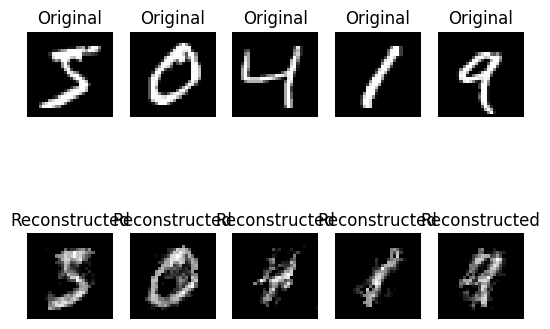

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a model defined as 'model' which takes input of shape [None, patch_size**2 + num_patches]
# and outputs the reconstructed image flattened.

# Assuming 'extract_and_shuffle_patches' function is defined correctly as discussed before
# Initialize the model

# image_height, image_width = 28, 28  # For example, with MNIST
# patch_size = 4
# stride = 4
# units = 64
# output_size = image_height * image_width  # Flattened image reconstruction

# model = ImageReconstructionRNN(patch_size, stride, patch_size**2, units, output_size)
# Prepare dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

# Extract and shuffle patches for the first batch as an example
patch_size = 4
stride = 4
num_patches = (28 // stride) * (28 // stride)
train_patches = extract_and_shuffle_patches(x_train[:32], patch_size, stride)

# Prepare the target images (flattened)
train_targets = x_train[:32].reshape(32, -1)  # Flatten the images

# Define loss and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

# Training loop
epochs = 10
for epoch in range(epochs):
    if epoch%10 == 0:  print(f'Epoch {epoch+1}/{epochs}')
    with tf.GradientTape() as tape:
        # Forward pass through the model
        predictions = model(train_patches)
        # Compute the loss value
        loss_value = loss_fn(train_targets, predictions)

    # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss
    grads = tape.gradient(loss_value, model.trainable_variables)

    # Run one step of gradient descent by updating the value of the variables to minimize the loss
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Log every epoch
    if epoch%10 == 0: print(f"Training loss (for one batch): {loss_value.numpy():.4f}")

# After training, you can visualize some reconstructed images
predicted_images = model.predict(train_patches)
num_images_to_show = 5

for i in range(num_images_to_show):
    # Original Image
    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(2, num_images_to_show, num_images_to_show + i + 1)
    plt.imshow(predicted_images[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()


Set mask to 0

In [ ]:
import tensorflow as tf
import numpy as np

def extract_and_shuffle_patches(images, patch_size, stride, mask=0):
    batch_size, height, width, channels = images.shape
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, stride, stride, 1],
        rates=[1, 1, 1, 1],
        padding='SAME'
    )
    # Calculate number of patches and reshape to (batch_size, num_patches, patch_features)
    num_patches = (height // stride) * (width // stride)
    patch_features = patch_size * patch_size * channels
    patches = tf.reshape(patches, [batch_size, num_patches, patch_features])

    # Create a one-hot encoded positions matrix
    positions = tf.eye(num_patches, dtype=patches.dtype)  # One-hot encoding of positions
    positions = tf.tile(positions[tf.newaxis, :, :], [batch_size, 1, 1])  # Expand to batch size

    # Concatenate patches with positions
    full_inputs = tf.concat([patches, positions], axis=-1)

    # Shuffle patches and positions within each batch
    shuffled_inputs = tf.map_fn(tf.random.shuffle, full_inputs)

    # Determine how many patches to keep based on the mask percentage
    num_patches_to_keep = num_patches - int(num_patches * mask / 100)

    # Select a subset of patch-position pairs for each image in the batch
    reduced_inputs = shuffled_inputs[:, :num_patches_to_keep, :]

    return reduced_inputs

# Example usage with MNIST
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

# Extract patches with a 50% mask
patch_size = 4
stride = 4
mask = 60  # Mask 50% of the patches
inputs = extract_and_shuffle_patches(x_train[:10], patch_size, stride, mask)

print(f"Input shape: {inputs.shape}")  # Should show a reduced sequence length


Input shape: (10, 20, 65)


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'extract_and_shuffle_patches' and 'ImageReconstructionRNN' are defined as discussed
# Prepare dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)

# Extract and shuffle patches for training
train_patches= extract_and_shuffle_patches(x_train, patch_size, stride)
train_targets = x_train.reshape(-1, image_height * image_width)

# Initialize the model
model = ImageReconstructionRNN(patch_size, stride, patch_size**2 + num_patches, units, output_size)
model.compile(optimizer='adam', loss='mean_squared_error')

# Training loop
epochs = 100
for epoch in range(epochs):
    # Training
    model.fit(train_patches, train_targets, epochs=1, verbose=0)
    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}')

# Visualization after training
num_images_to_show = 5
test_indices = np.random.choice(x_test.shape[0], num_images_to_show, replace=False)
test_patches, _, _ = extract_and_shuffle_patches(x_test[test_indices], patch_size, stride)

predicted_images = model.predict(test_patches)

# Plotting
plt.figure(figsize=(10, 4))
for i in range(num_images_to_show):
    # Original Image
    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(x_test[test_indices[i]].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(2, num_images_to_show, num_images_to_show + i + 1)
    plt.imshow(predicted_images[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()


Epoch 1/100
Epoch 11/100
Epoch 21/100
Epoch 31/100
Epoch 41/100
Epoch 51/100
Epoch 61/100
Epoch 71/100
Epoch 81/100
Epoch 91/100


ValueError: too many values to unpack (expected 3)